# Praca domowa 2 - Bartosz Rożek

Pracuję na zbiorze projektowym - ceny mieszkań w Kalifornii

In [1]:
setwd("/home/bartosz/Documents/studia/sem6/wb2/")

Wczytanie zbioru i jakiś preprocessing

In [2]:
housing <- read.csv("housing.csv")

housing$total_bedrooms[is.na(housing$total_bedrooms)] = median(housing$total_bedrooms , na.rm = TRUE)

housing$mean_bedrooms = housing$total_bedrooms/housing$households
housing$mean_rooms = housing$total_rooms/housing$households

drops = c('total_bedrooms', 'total_rooms')

housing = housing[ , !(names(housing) %in% drops)]
colnames(housing)

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "population"         "households"         "median_income"     
 [7] "median_house_value" "ocean_proximity"    "mean_bedrooms"     
[10] "mean_rooms"

In [3]:
set.seed(1738) # Set a random seed so that same sample can be reproduced in future runs

sample = sample.int(n = nrow(housing), size = floor(.8*nrow(housing)), replace = F)
train = housing[sample, ] #just the samples
test  = housing[-sample, ] #everything but the samples

In [4]:
train_y = train[,'median_house_value']
train_x = train[, names(train) !='median_house_value']

## Model

Używam modelu z kaggle - random forest

In [5]:
library('randomForest')
rf_model = randomForest(train_x, y = train_y , ntree = 500, importance = TRUE)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



### Predykcja modelu

In [6]:
predict(rf_model, housing[1, -7])

1 
435690.9

### Explainer 

In [7]:
library(DALEX)
library(DALEXtra)
explainer <- DALEX::explain(model = rf_model,
                     data = housing[, -7],
                     y = housing[, 7])

Welcome to DALEX (version: 2.2.0).
Find examples and detailed introduction at: http://ema.drwhy.ai/


Anaconda not found on your computer. Conda related functionality such as create_env.R and condaenv and yml parameters from explain_scikitlearn will not be available



Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  20640  rows  9  cols 
  -> target variable   :  20640  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  39999.6 , mean =  207130.9 , max =  500001  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -296358.5 , mean =  -275.114 , max =  334253.2  
  A new explainer has been created!  


In [9]:
library("lime")
library("ggplot2")
model_type.dalex_explainer <- DALEXtra::model_type.dalex_explainer
predict_model.dalex_explainer <- DALEXtra::predict_model.dalex_explainer


Attaching package: ‘lime’


The following object is masked from ‘package:DALEX’:

    explain



Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




### Dekompozycja lime dla jednej obserwacji

In [19]:
lime_pr <- predict_surrogate(explainer = explainer, 
                                 new_observation = housing[c(1,sample(nrow(housing), 200)), -7], 
                                 n_features = 9, 
                                 n_permutations = 1000,
                                 type = "lime")

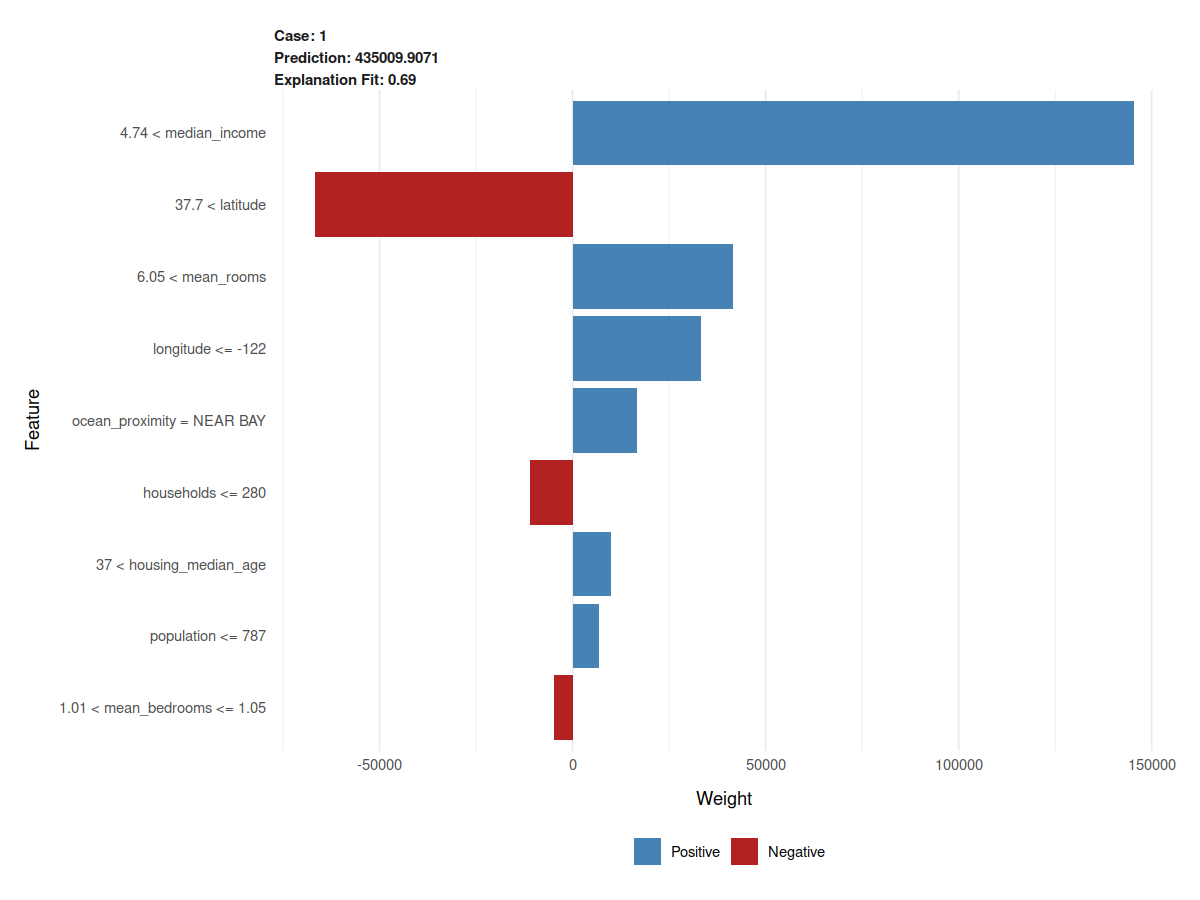

In [20]:
options(repr.plot.width=10, repr.plot.height=7.5)
plot(lime_pr[1:9,])

Jak widzimy, nasza predykcja głównie opiera się na medianie przychodu i szerokości geograficznej. Jak pokazaliśmy na projekcie, szerokość i długość geograficzna (4 co do największego wpływu zmienna) są bardzo mocno skorelowane ujemnie. W naszym wyjaśnieniu mają współczynniki o przeciwnych znakach i bardzo dobrze, bo w przeciwnym wypadku nie miałoby to sensu. Warto też zauważyć, że nasze wyjaśnienie pokazuje po lewej stronie, że model zamienił ciągłe zmienne na dyskretne, dzieląc oś na przedziały.

### Porównanie dla różnych obserwacji

Dla każdej zmiennej (pomijając latitude, ponieważ jest bardzo skorelowane z longitude) znalazłem obserwacje o tej samej lub bardzo podobnej wartości i porównałem jaki wpływ mają na predykcję.

#### Longitude

In [63]:
lime_pr_longitude_125 <- predict_surrogate(explainer = explainer, 
                                 new_observation = housing[c(1851,2544), -7], 
                                 n_features = 9, 
                                 n_permutations = 1000,
                                 type = "lime")

lime_pr_longitude_125[c(1,10),]

model_type,case,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<list>,<dbl>
regression,1851,0.1788227,247820.0,245864.3,longitude,-124.17,33072.38,longitude <= -122,"-124.17 , 41.8 , 16 , 1259 , 436 , 3.7557 , NEAR OCEAN , 1.10091743119266, 6.28211009174312",116639.93
regression,2544,0.3503806,274043.9,158055.2,longitude,-124.16,32392.58,longitude <= -122,"-124.16 , 40.79 , 52 , 975 , 430 , 2.2566 , NEAR OCEAN , 0.97906976744186, 4.9953488372093",92179.22


Bardzo zbliżony wpływ

#### Housing_median_age

In [60]:
lime_pr_housing_median_age_10 <- predict_surrogate(explainer = explainer, 
                                 new_observation = housing[c(88,700), -7], 
                                 n_features = 9, 
                                 n_permutations = 1000,
                                 type = "lime")

lime_pr_housing_median_age_10[c(3,12),]

model_type,case,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<list>,<dbl>
regression,88,0.2726458,268144.9,177141.5,housing_median_age,10,-2148.086,housing_median_age <= 18,"-122.27 , 37.81 , 10 , 546 , 330 , 0.76 , NEAR BAY , 1.05454545454545, 2.65151515151515",154913.9
regression,700,0.1689252,252926.7,208754.3,housing_median_age,10,-2342.224,housing_median_age <= 18,"-122.12 , 37.69 , 10 , 1140 , 472 , 2.3973 , NEAR BAY , 1.1864406779661 , 4.71822033898305",162150.2


Bardzo zbliżony wpływ

#### Population

In [68]:
lime_pr_population_3500 <- predict_surrogate(explainer = explainer, 
                                 new_observation = housing[c(925,3388), -7], 
                                 n_features = 9, 
                                 n_permutations = 1000,
                                 type = "lime")

lime_pr_population_3500[c(4,13),]

model_type,case,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<list>,<dbl>
regression,925,0.56361874,190689,373369.6,population,3571,-4864.374,1725 < population,"-121.92 , 37.49 , 10 , 3571 , 1466 , 5.1643 , <1H OCEAN , 1.08321964529332, 5.07571623465211",226066.2
regression,3388,0.07094214,232229,279095.8,population,3540,-10894.763,1725 < population,"-118.33 , 34.24 , 31 , 3540 , 1131 , 4.2639 , <1H OCEAN , 1.05039787798408, 5.68877099911583",253714.9


Ten sam wpływ (negatywny), jednak na jedną obserwację wpływa dwa razy bardziej.

#### Households

In [71]:
lime_pr_households_30 <- predict_surrogate(explainer = explainer, 
                                 new_observation = housing[c(1365,5376), -7], 
                                 n_features = 9, 
                                 n_permutations = 1000,
                                 type = "lime")

lime_pr_households_30[c(5,14),]

model_type,case,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<list>,<dbl>
regression,1365,0.23944029,257731.4,190153.6,households,30,-5164.507,households <= 280,"-122.14 , 38.03 , 42 , 54 , 30 , 2.5795 , NEAR BAY , 1.13333333333333, 3.93333333333333",164189.5
regression,5376,0.08052252,230876.2,270534.0,households,30,-18773.653,households <= 280,"-118.39 , 34.04 , 41 , 85 , 30 , 4.125 , <1H OCEAN , 0.766666666666667, 3.36666666666667",254595.8


Ten sam wpływ (negatywny), jednak na jedną obserwację wpływa dwa razy bardziej.

#### Median income

In [72]:
lime_pr_median_income_4 <- predict_surrogate(explainer = explainer, 
                                 new_observation = housing[c(6,274), -7], 
                                 n_features = 9, 
                                 n_permutations = 1000,
                                 type = "lime")

lime_pr_median_income_4[c(6,15),]

model_type,case,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<list>,<dbl>
regression,6,0.1473322,250236.5,255797.2,median_income,4.0368,-14944.3,3.53 < median_income <= 4.74,"-122.25 , 37.85 , 52 , 413 , 193 , 4.0368 , NEAR BAY , 1.10362694300518, 4.76165803108808",243867.2
regression,274,0.1487198,259054.6,217450.0,median_income,4.5893,-18798.2,3.53 < median_income <= 4.74,"-122.2 , 37.78 , 45 , 869 , 327 , 4.5893 , NEAR BAY , 1.01529051987768, 5.40061162079511",186366.1


Podobny wpływ

#### Ocean_proximity

In [75]:
lime_pr_near_bay <- predict_surrogate(explainer = explainer, 
                                 new_observation = housing[c(1,18922), -7], 
                                 n_features = 9, 
                                 n_permutations = 1000,
                                 type = "lime")

lime_pr_near_bay[c(7,16),]

model_type,case,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<list>,<dbl>
regression,1,0.6741847,211598.4,354616.3,ocean_proximity,NEAR BAY,-5007.378,ocean_proximity = NEAR BAY,"-122.23 , 37.88 , 41 , 322 , 126 , 8.3252 , NEAR BAY , 1.02380952380952, 6.98412698412698",418921.2
regression,18922,0.6604446,212128.6,341277.9,ocean_proximity,NEAR BAY,-5816.573,ocean_proximity = NEAR BAY,"-122.18 , 38.07 , 10 , 2089 , 803 , 5.3288 , NEAR BAY , 1.05728518057285, 6.19676214196762",205480.6


Dosyć podobny wpływ

#### Mean bedroms

In [78]:
lime_pr_mean_bedrooms <- predict_surrogate(explainer = explainer, 
                                 new_observation = housing[c(6,20481), -7], 
                                 n_features = 9, 
                                 n_permutations = 1000,
                                 type = "lime")

lime_pr_mean_bedrooms[c(8,17),]

model_type,case,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<list>,<dbl>
regression,6,0.14551162,250473.3,218732.2,mean_bedrooms,1.10362694300518,13060.425,1.10 < mean_bedrooms,"-122.25 , 37.85 , 52 , 413 , 193 , 4.0368 , NEAR BAY , 1.10362694300518, 4.76165803108808",232401.8
regression,20481,0.03750096,227162.2,248472.8,mean_bedrooms,1.11845102505695,5907.492,1.10 < mean_bedrooms,"-118.7 , 34.28 , 25 , 1200 , 439 , 4.7083 , <1H OCEAN , 1.11845102505695, 5.41457858769932",239018.4


Ten sam wpływ (pozytywny), jednak na jedną obserwację wpływa bardziej.

In [81]:
lime_pr_mean_rooms <- predict_surrogate(explainer = explainer, 
                                 new_observation = housing[c(7,19862), -7], 
                                 n_features = 9, 
                                 n_permutations = 1000,
                                 type = "lime")

lime_pr_mean_rooms[c(9,18),]

model_type,case,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<list>,<dbl>
regression,7,0.1770242,256446.7,235774.3,mean_rooms,4.93190661478599,-26752.44,4.44 < mean_rooms <= 5.23,"-122.25 , 37.84 , 52 , 1094 , 514 , 3.6591 , NEAR BAY , 0.95136186770428, 4.93190661478599",250565.82
regression,19862,0.2307774,287341.7,140289.0,mean_rooms,4.90291262135922,-22394.96,4.44 < mean_rooms <= 5.23,"-119.3 , 36.34 , 27 , 1178 , 309 , 1.4432 , INLAND , 1.15857605177994, 4.90291262135922",50283.77


Dosyć podobny wpływ

### Podsumowanie

Wszystkie zmienne mają wpływ tego samego znaku, w większości jest on bardzo podobny.

### Histogram przedstawia rozkład wpływu danej cechy na predykcję modelu. 

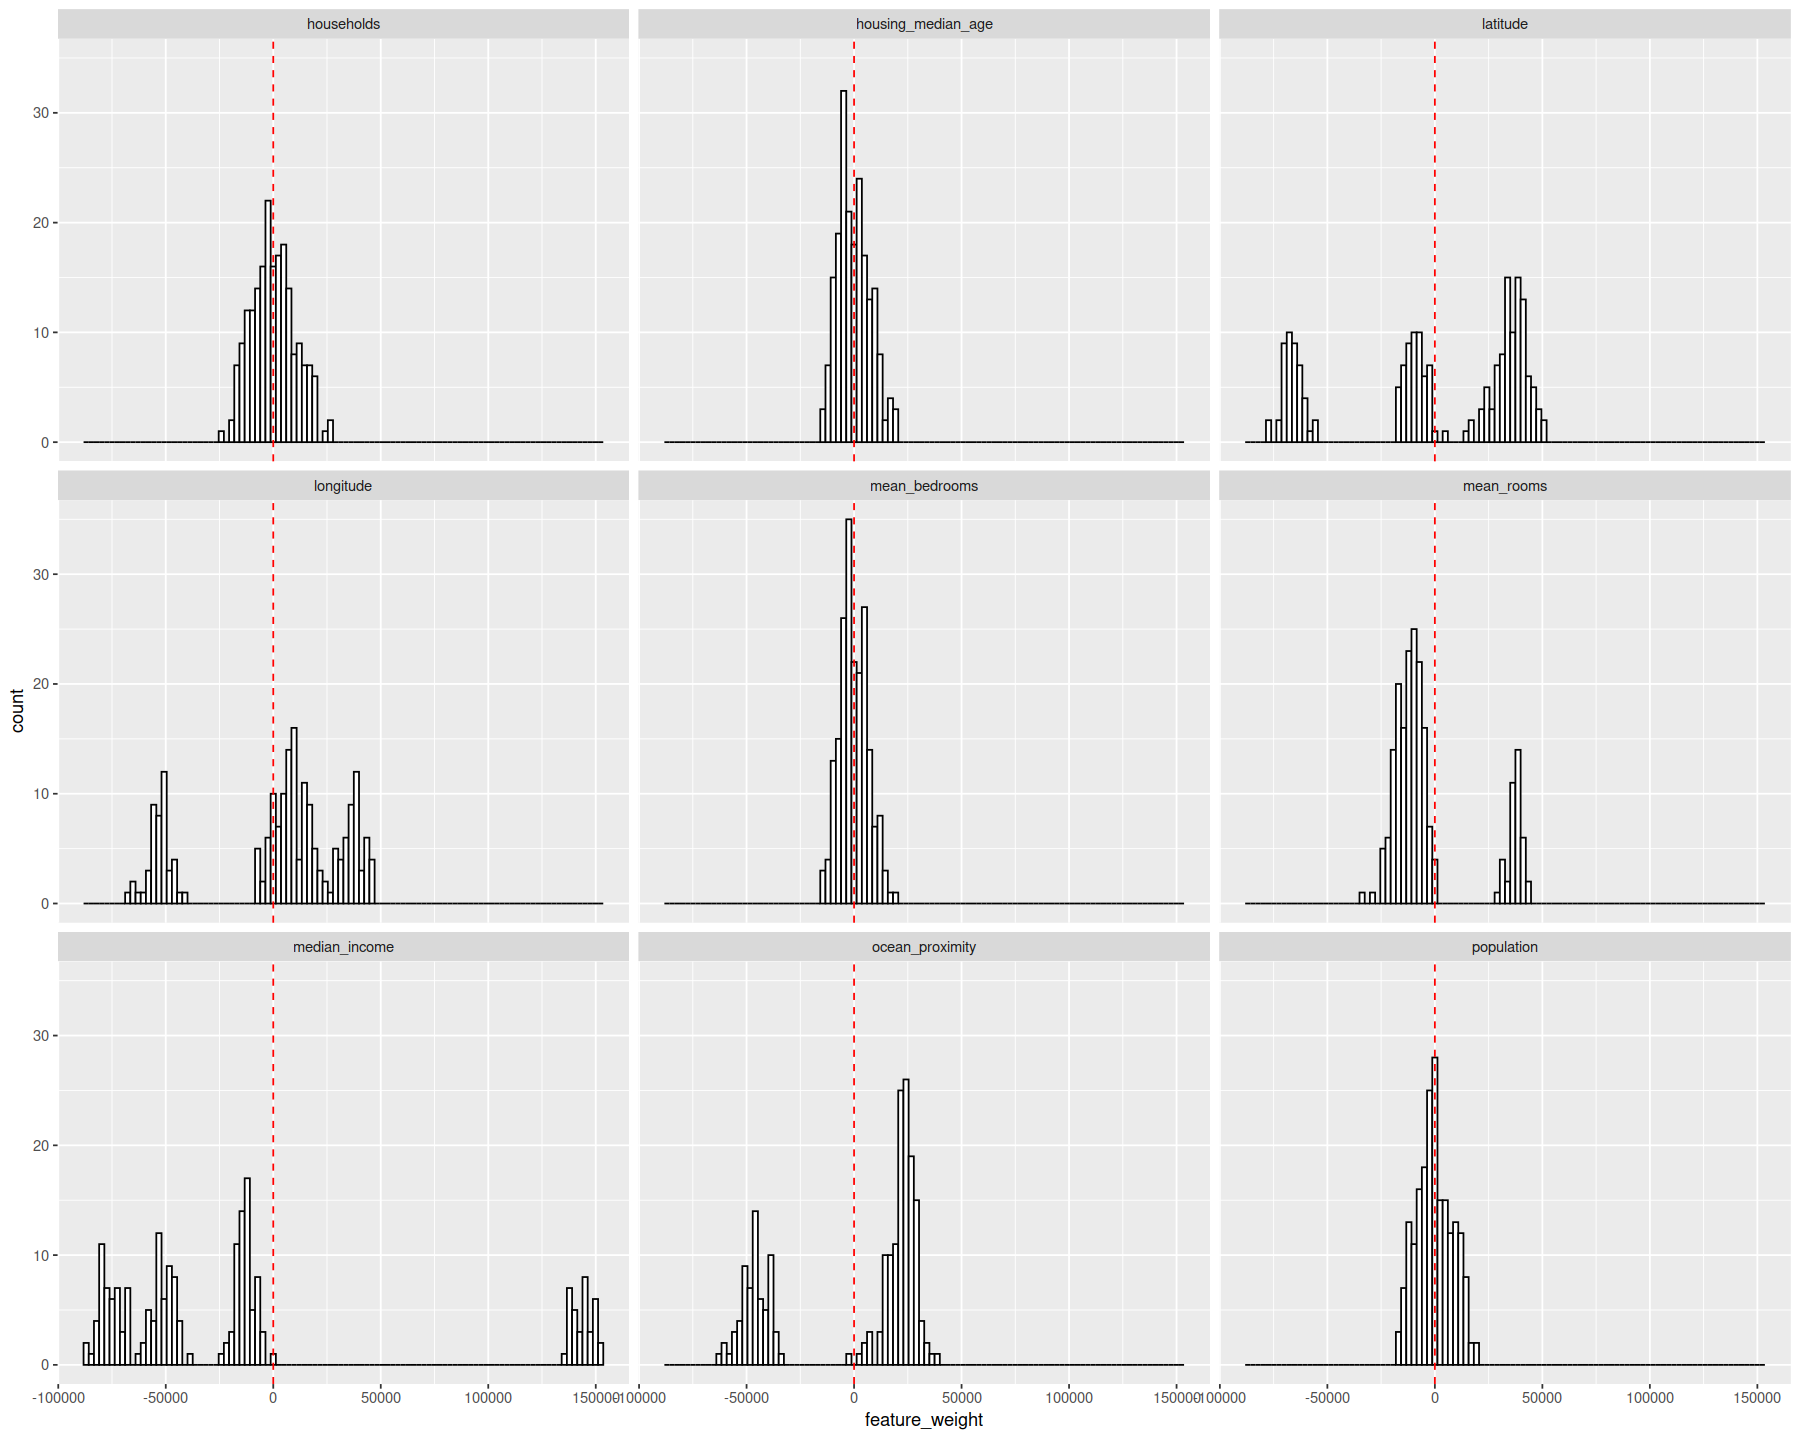

In [13]:
options(repr.plot.width=15, repr.plot.height=12)

ggplot(lime_pr, aes(x=feature_weight)) + 
 geom_histogram(colour="black", fill="white", bins=100)+ 
 geom_vline(xintercept=0, linetype="dashed", color = "red") +
 facet_wrap(~feature)

Widzimy na nim, że większość zmiennych ma rozkład symetryczny o środku w zerze, co wydaje się naturalne. Ciekawić mogą zmienne, które mają rozkłady które mają pare "słupków". Szczególnie dziwić może *median_income*

Postanowiłem poszukać jakiejś zależności dla obserwacji z bardzo dużym wpływem *median_income*

In [128]:
mi <- lime_pr[lime_pr[,"feature"] == "median_income",c("case", "feature_weight")]
high_mi <- mi[mi$feature_weight > 140000,"case"]

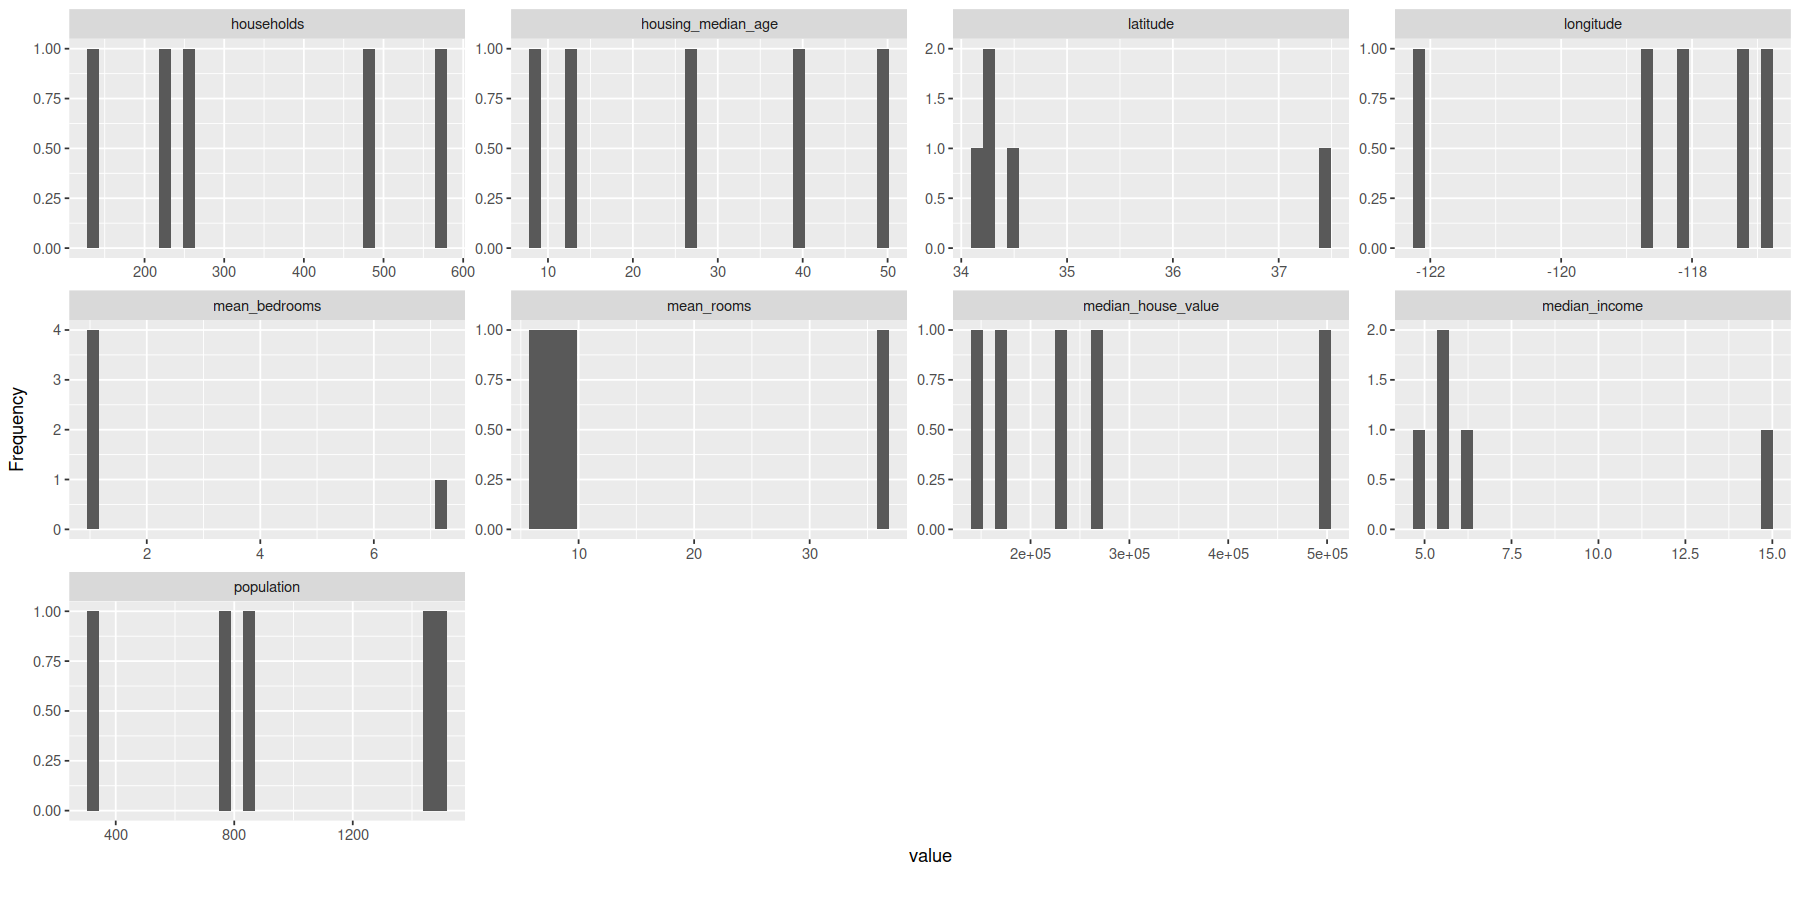

In [141]:
DataExplorer::plot_histogram(housing[unlist(high_mi),])

Prawdę mówiąc nie widzę żadnego wytłumaczenia.

## Porównanie z break down

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



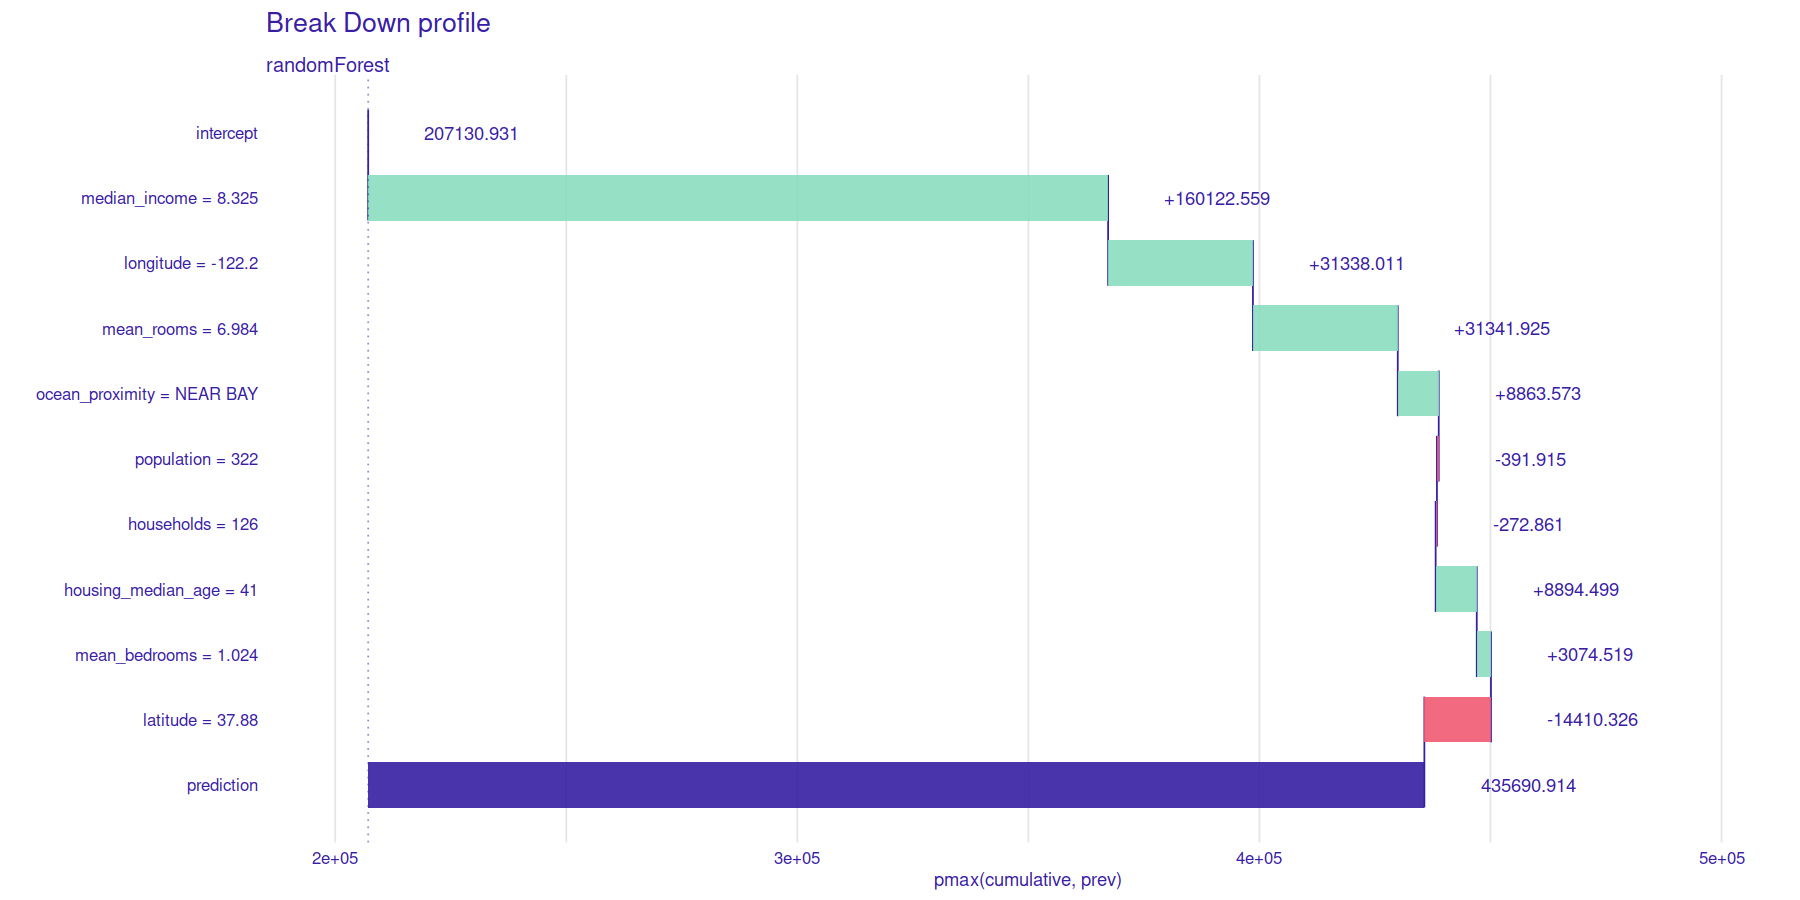

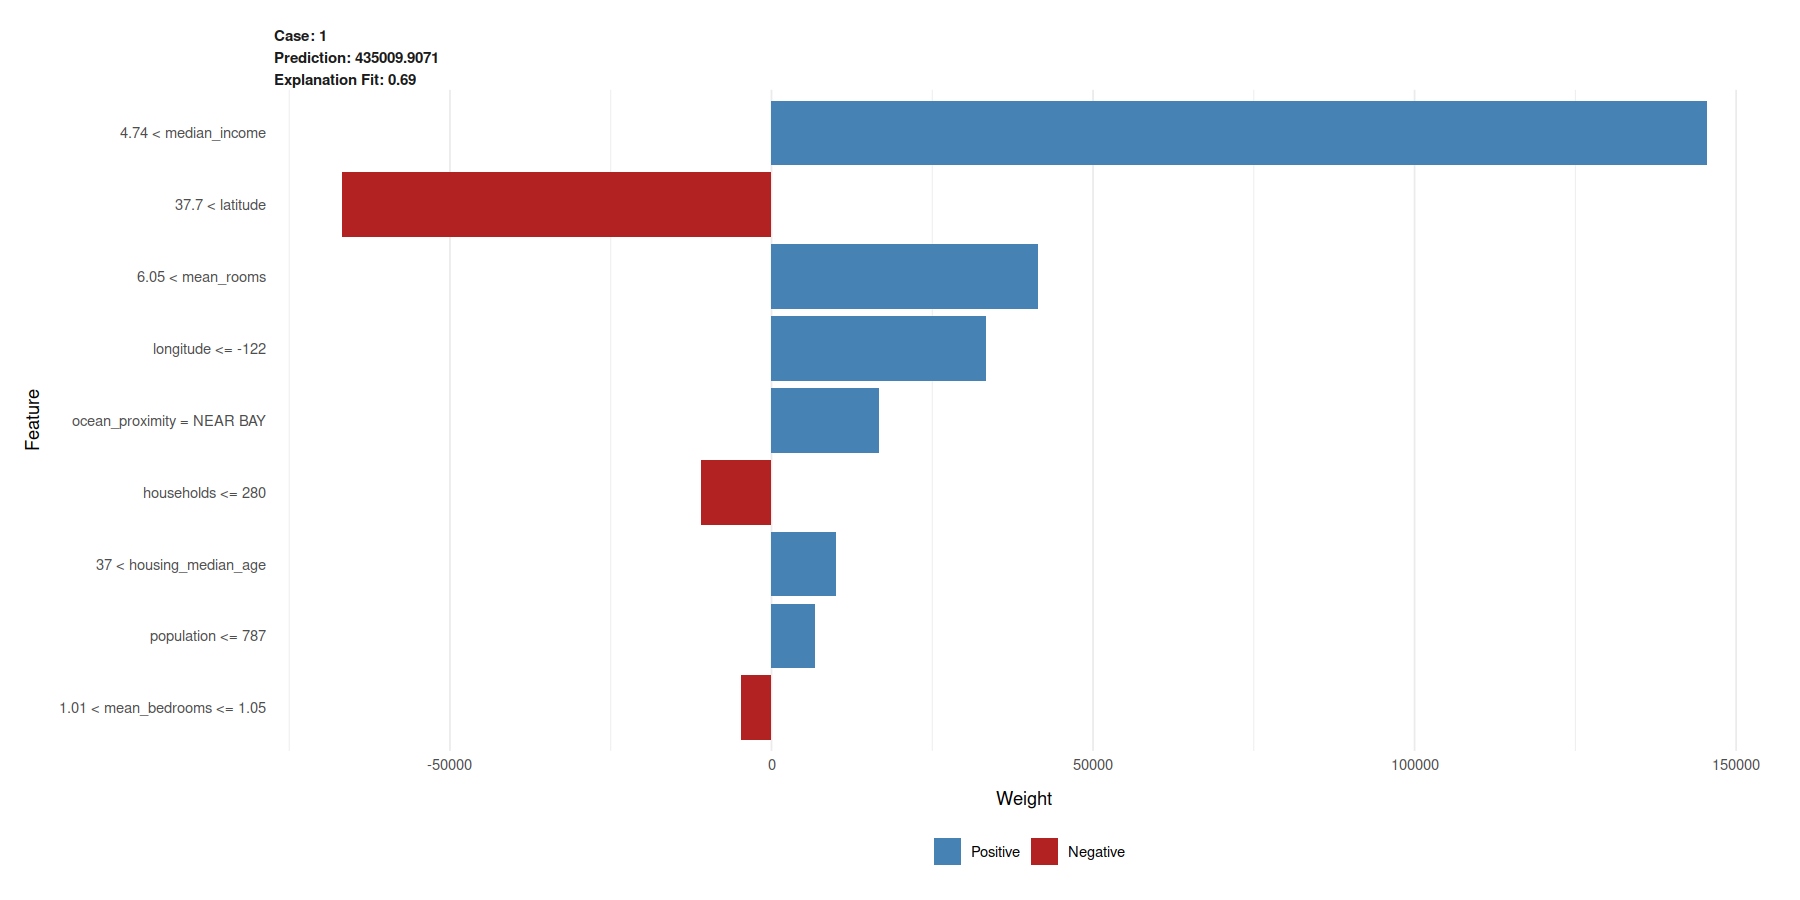

In [142]:
rf_bd <- predict_parts(explainer, new_observation = housing[1,])
plot(rf_bd) + ylim(200000,500000)
plot(lime_pr[1:9,])

Jedynie *population* ma inny znak. Główne zmienne są takie same, jeżeli weźmiemy pod uwagę dużą korelację między latitude i longitude (z tej korelacji może wynikać że zmienne "przekazują" między sobą wpływ).